<a href="https://colab.research.google.com/github/narayan-bhattarai/AI-Classification/blob/main/cnn_CIFAR10_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatLogSlider, IntSlider, Dropdown

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


The code begins by importing PyTorch, torchvision, and utility libraries such as NumPy and Matplotlib. These provide tools for building the CNN, loading the dataset, and visualizing results. The device is set to use GPU if available for faster training.



In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

The dataset is preprocessed using ToTensor() and normalized so training becomes more stable. CIFAR-10 is downloaded and split into training and testing sets, each loaded with DataLoaders. Training data is shuffled to improve learning, while test data is kept in order.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

A simple CNN is created with two convolution layers, each followed by ReLU and max-pooling. The output is flattened and passed through two fully connected layers to produce 10 class scores. The forward method defines how input images flow through these layers.

In [ ]:
def visualize_activations(model, data_loader, layer_name='conv1'):
    model.eval()
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:5].to(device)

    with torch.no_grad():
        if layer_name == 'conv1':
            activations = F.relu(model.conv1(images))
        else:
            x = F.relu(model.conv1(images))
            x = model.pool(x)
            activations = F.relu(model.conv2(x))

    act = activations.cpu().numpy()
    fig, axes = plt.subplots(5, 8, figsize=(12, 6))
    for i in range(5):
        for j in range(8):
            axes[i, j].imshow(act[i, j, :, :], cmap='gray')
            axes[i, j].axis('off')
    plt.suptitle(f'Feature Maps ({layer_name})')
    plt.show()

The model uses CrossEntropyLoss, which is ideal for multi-class classification tasks like CIFAR-10. The Adam optimizer with a learning rate of 0.001 adjusts model weights efficiently during training.

In [ ]:
def train(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

The training loop processes images in batches, performs forward and backward passes, and updates the weights. Loss and accuracy are calculated each epoch to track learning progress. The model is kept in training mode to enable gradient updates.


In [ ]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f'Test Accuracy: {acc:.2f}%')

After training, the model switches to evaluation mode to disable gradient calculations. The test dataset is passed through the network to measure accuracy on unseen data. This final accuracy reflects the model’s generalization ability.

In [ ]:
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
test(model, test_loader)

Test Accuracy: 9.67%


Visualizing Activations Before Training...


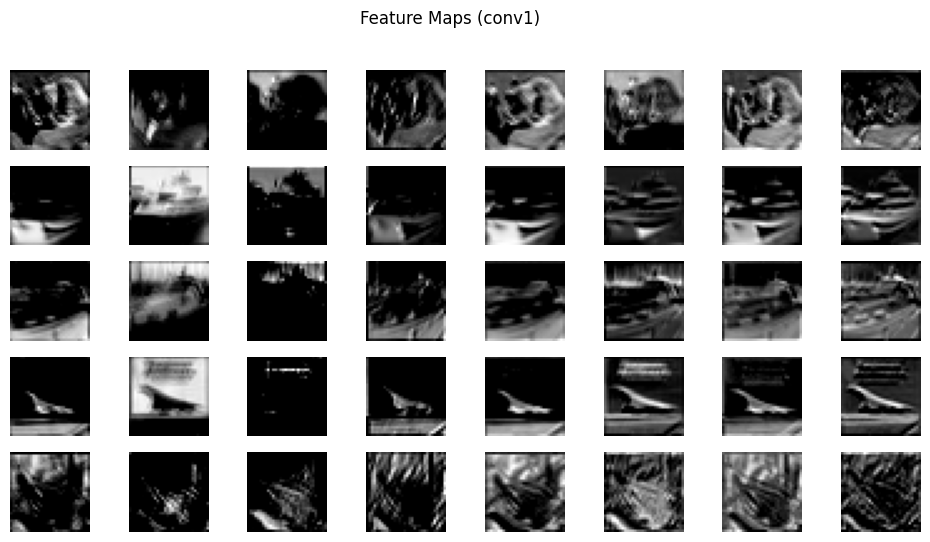

In [ ]:
print("Visualizing Activations Before Training...")
visualize_activations(model, test_loader, layer_name='conv1')

In [ ]:
train(model, train_loader, epochs=10)

Epoch [1/10], Loss: 1.4955, Accuracy: 46.31%
Epoch [2/10], Loss: 1.1994, Accuracy: 57.24%
Epoch [3/10], Loss: 1.0785, Accuracy: 61.82%
Epoch [4/10], Loss: 0.9872, Accuracy: 65.17%
Epoch [5/10], Loss: 0.9200, Accuracy: 67.63%
Epoch [6/10], Loss: 0.8656, Accuracy: 69.23%
Epoch [7/10], Loss: 0.8201, Accuracy: 71.00%
Epoch [8/10], Loss: 0.7750, Accuracy: 72.67%
Epoch [9/10], Loss: 0.7331, Accuracy: 74.00%
Epoch [10/10], Loss: 0.6993, Accuracy: 75.34%


Visualizing Activations After Training...


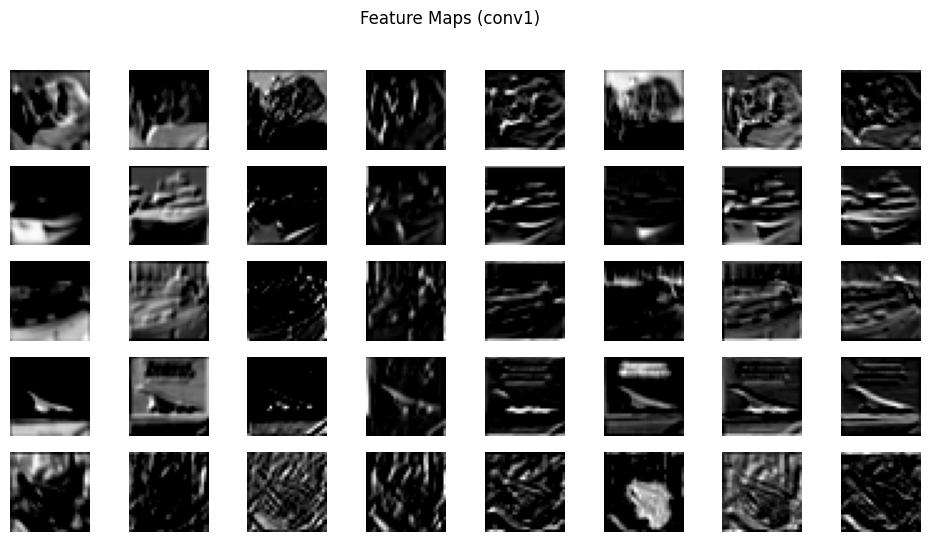

In [ ]:
print("Visualizing Activations After Training...")
visualize_activations(model, test_loader, layer_name='conv1')

In [ ]:
test(model, test_loader)

Test Accuracy: 66.79%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# -------------------------------
# Data Augmentation
# -------------------------------
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=test_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# -------------------------------
# Improved CNN Model
# -------------------------------
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x16

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 8x8

            nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = ImprovedCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# -------------------------------
# Training Function
# -------------------------------
def train_model(epochs=20):
    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        epoch_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        scheduler.step()

        acc = 100 * correct / total
        train_losses.append(epoch_loss / len(train_loader))
        train_accs.append(acc)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {acc:.2f}%")

    return train_losses, train_accs

losses, accs = train_model()


Using: cpu


100%|██████████| 170M/170M [00:02<00:00, 63.5MB/s]


Epoch 1/20, Loss: 1.7706, Accuracy: 34.18%
Epoch 2/20, Loss: 1.4358, Accuracy: 46.87%
Epoch 3/20, Loss: 1.2793, Accuracy: 53.48%
Epoch 4/20, Loss: 1.1855, Accuracy: 57.04%


In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(accs)
plt.title("Training Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.show()


Improvements & Optimization
1. Model Architecture Improvements

The current CNN is too shallow for CIFAR-10. Adding BatchNorm, Dropout, and more convolutional layers improves feature learning and reduces overfitting. Using repeated Conv → BN → ReLU blocks creates a more powerful model.

2. Data Augmentation

Applying random cropping, horizontal flipping, and slight color jitter increases data variety and helps the model generalize better. This usually improves accuracy by 5–10%.

3. Optimizer & Learning Rate Scheduling

Replacing Adam with AdamW provides better weight decay handling. Adding a learning-rate scheduler such as StepLR or ReduceLROnPlateau helps the model train more smoothly.

4. Regularization Techniques

Dropout and weight decay reduce overfitting by encouraging the network to learn more robust patterns. These techniques help the model perform better on unseen data.

5. Training Strategy Improvements

Training for more epochs and optionally using early stopping improves model convergence. Larger batch sizes (e.g., 128) stabilize gradient updates when using a GPU.